# Import Libraries

In [11]:
from glob import glob
import pandas as pd
import numpy as np
from typing import List
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib import pyplot as plt
import seaborn as sns

# Data Loading

In [2]:
datasets_paths = glob("../data/*.csv")
datasets: List[pd.DataFrame] = [pd.read_csv(path) for path in datasets_paths]

# Data Preparation

- Treat the records with `anomaly = True` from the dataset, and then impute them.
- Remove the `anomaly` column from the dataset.

In [3]:
for i, dataset in enumerate(datasets):
    if "anomaly" in dataset.columns:
        # Replace anomalies with 'NaN'
        dataset.loc[dataset.anomaly == 1, "value"] = np.nan

        # Remove the 'anomaly' column
        dataset = dataset.drop(columns=["anomaly"])

        # Update the dataset
        datasets[i] = dataset

- Convert the timestamp column to the `datetime` datatype
- Set the timestamp column as the index of the dataframe

In [4]:
for i, dataset in enumerate(datasets):
    # Convert the 'timestamp' column to datetime
    dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])

    # Set the 'timestamp' column as the index
    dataset = dataset.set_index("timestamp")

    # Update the dataset
    datasets[i] = dataset

- Remove Outliers

In [5]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def __zscore(self, X):
        X = np.nan_to_num(X, copy=True, nan=0)  # Convert the NaN values to 0
        return (X - np.mean(X)) / np.std(X)

    def transform(self, X: pd.DataFrame, y=None):
        """
        Calculate the z-score for each column in the DataFrame and remove the rows with z-score > threshold
        """

        X_copy = X.copy().to_numpy()
        for i in range(X_copy.shape[1]):
            column = X_copy[:, i]
            z_scores = self.__zscore(column)
            outliers = np.abs(z_scores) > self.threshold
            X_copy[outliers] = np.nan

        return X_copy

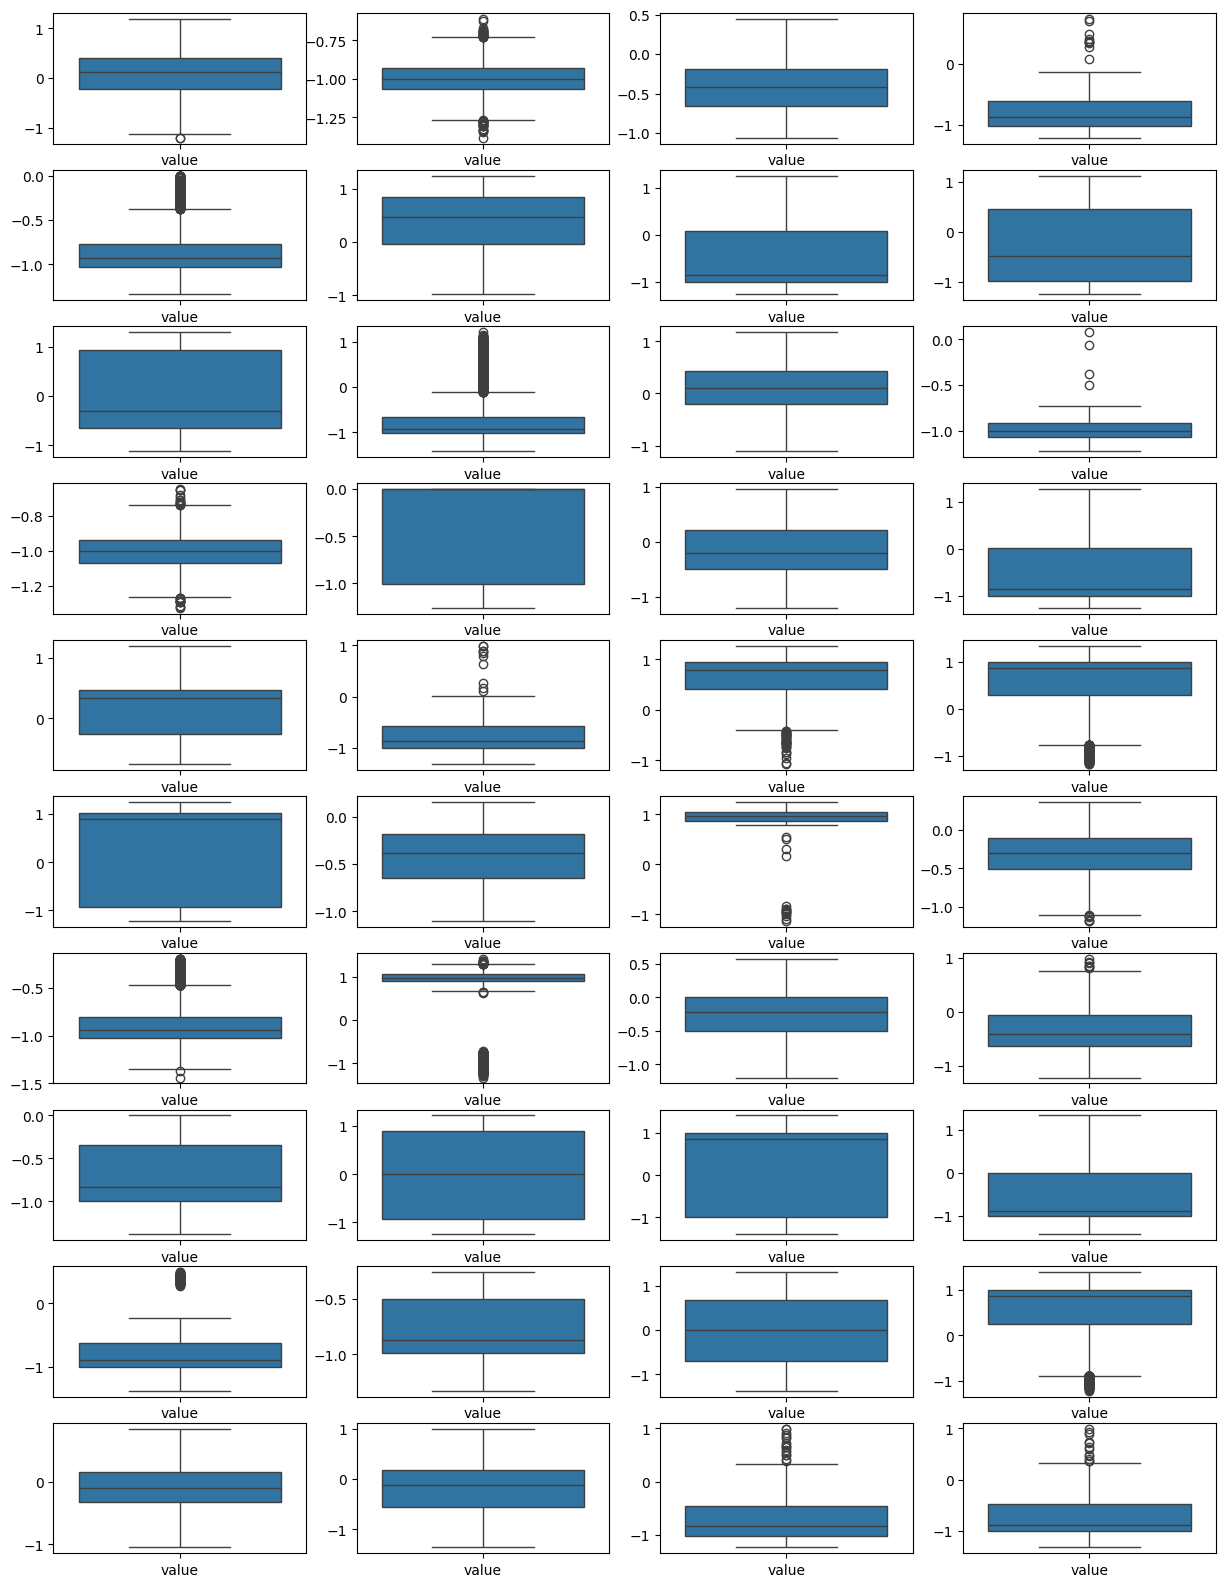

In [6]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))
for ax, dataset in zip(axes.ravel(), datasets):
    sns.boxplot(dataset, ax=ax)

plt.show()

In [7]:
# datasets values with no outliers
datasets_values = [
    OutlierTransformer(threshold=2).fit_transform(dataset) for dataset in datasets
]

In [8]:
# Update the datasets with the new values (without the outliers)
datasets = [
    pd.DataFrame(data=values, columns=dataset.columns, index=dataset.index)
    for values, dataset in zip(datasets_values, datasets)
]

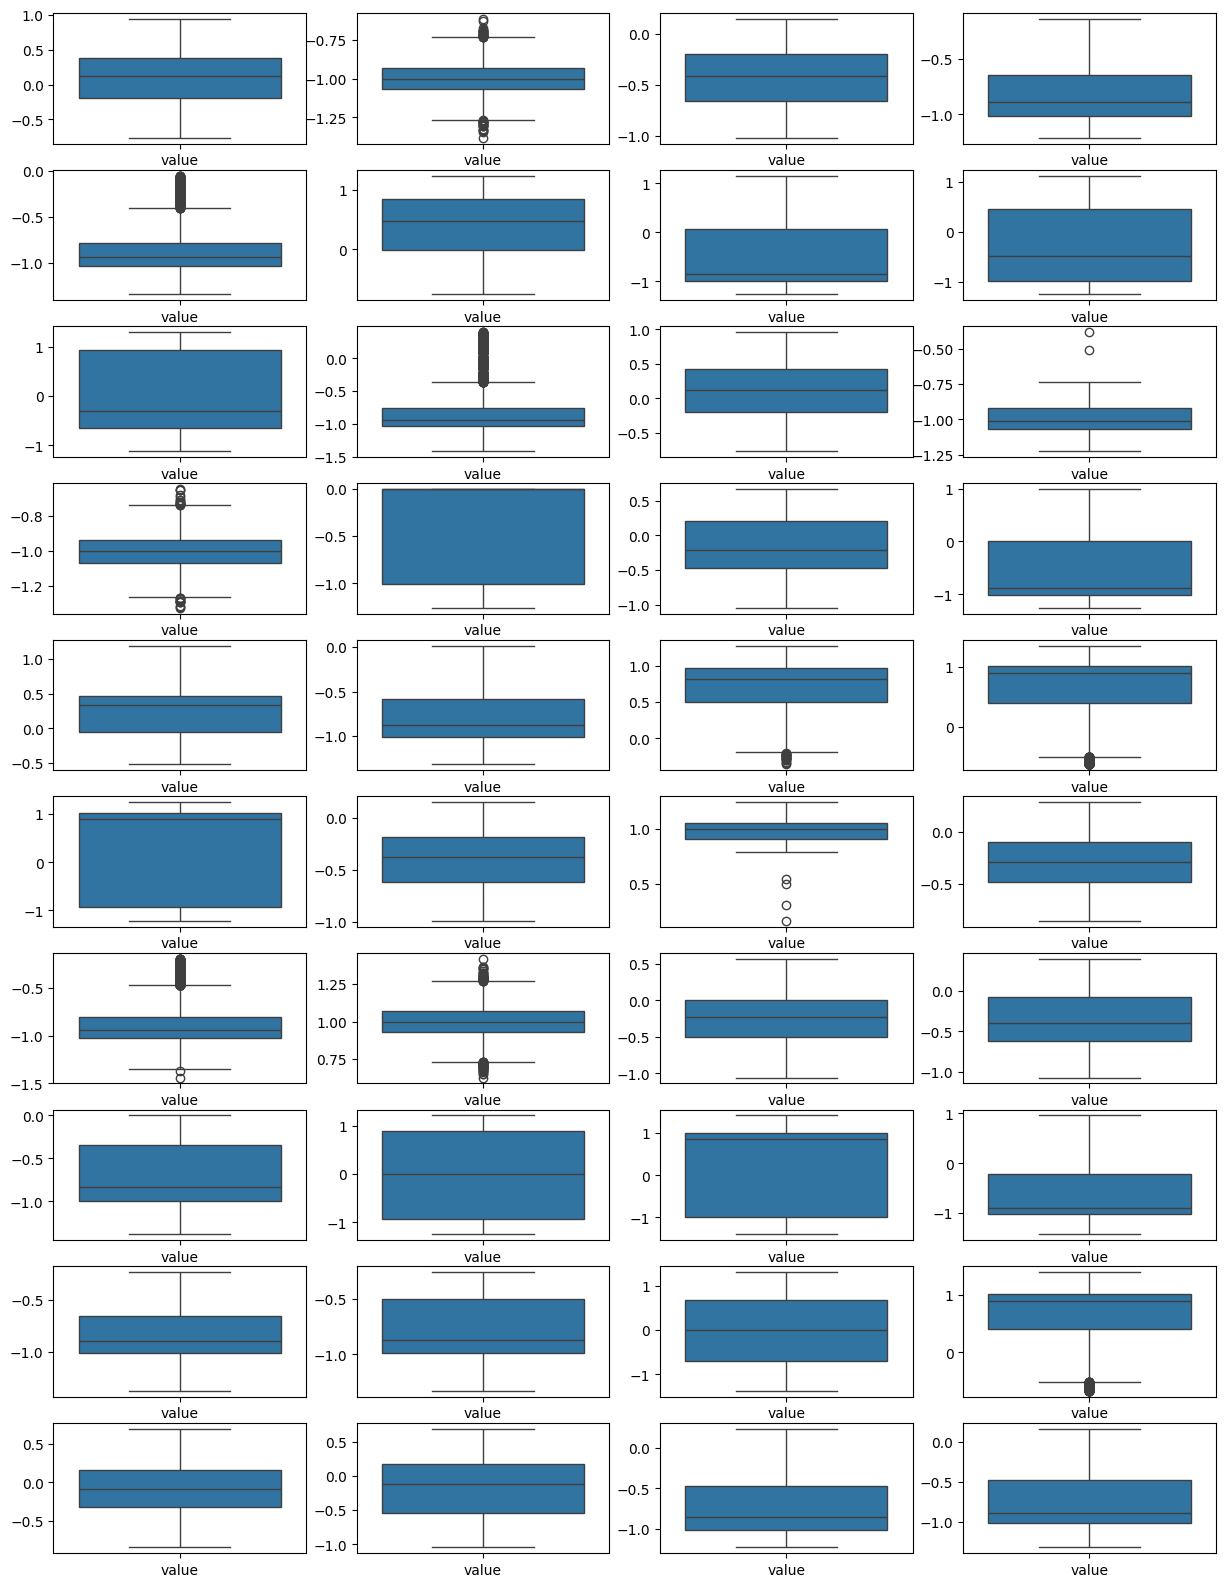

In [10]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))
for ax, dataset in zip(axes.ravel(), datasets):
    sns.boxplot(dataset, ax=ax)

plt.show()

# Data Preprocessing Pipeline

## Data Cleaning

- Impute missing values using `Interpolation`

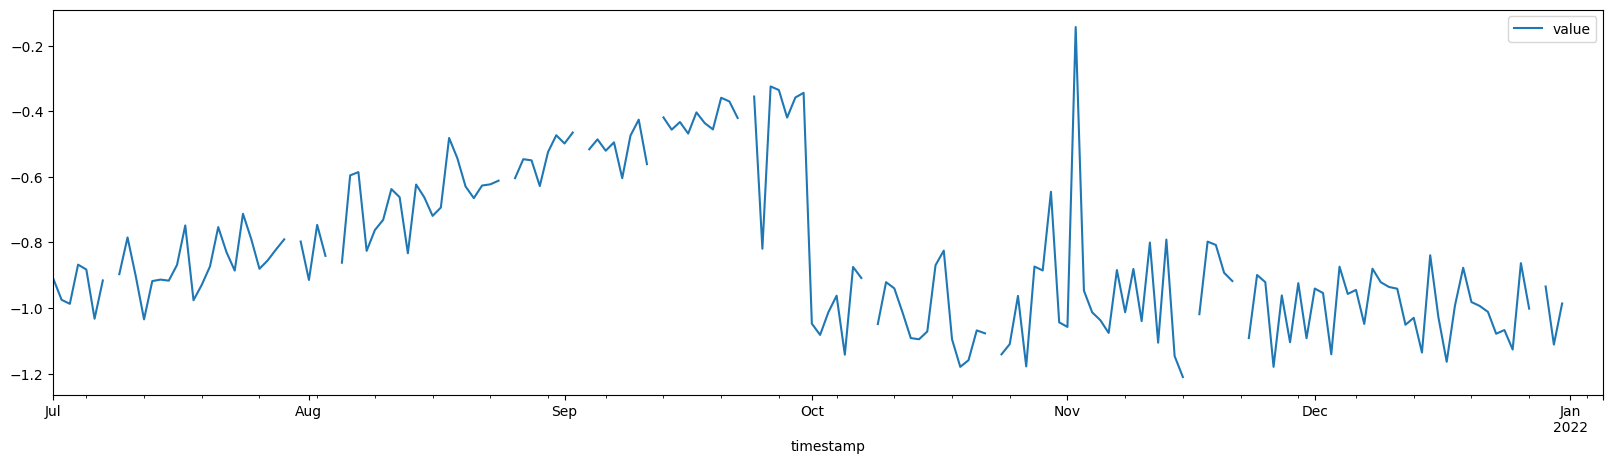

In [59]:
datasets[3].plot(figsize=(20, 5))
plt.show()

In [60]:
class InterpolationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method="linear"):
        self.method = method

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None):
        X_copy = X.copy()
        X_copy.interpolate(method=self.method, inplace=True)
        return X_copy.to_numpy()

In [65]:
interpolation_transformer = InterpolationTransformer(method="linear")
dataset_3_inter_values = interpolation_transformer.fit_transform(datasets[3])

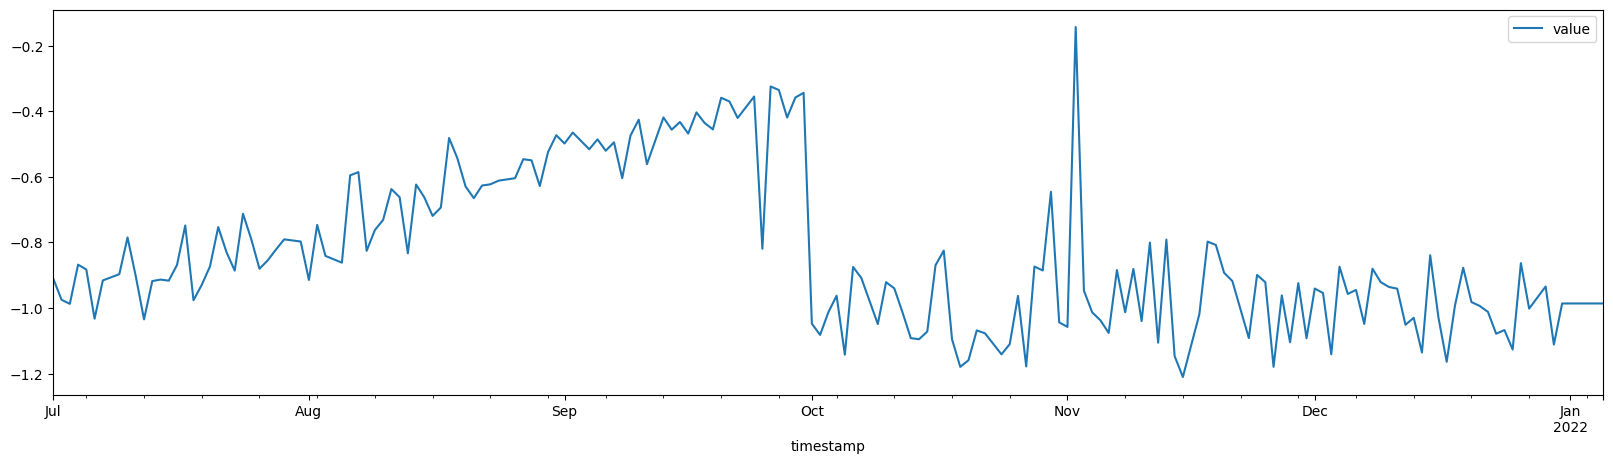

In [66]:
pd.DataFrame(
    data=dataset_3_inter_values, columns=datasets[3].columns, index=datasets[3].index
).plot(figsize=(20, 5))
plt.show()